# Flatfield IMC panorama image

The current notebook applies flatfielding to a IMC panorama image.

In [1]:
from pathlib import Path

import imageio
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from scipy.optimize import minimize
from scipy.stats import median_absolute_deviation as mad
import dask
import dask.array as da
from astropy.visualization import PercentileInterval

In [2]:
pano_name = Path("/home/eglez/Shared/msa51/imc-serial-sections/output_zarr/20220516_day12_144_serialsections_CM_20220516-213054-271411.zarr/snapshots/Panorama_2.png")

## Original Panorama

/tmp/ipykernel_695008/2523195028.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pano_img = imageio.imread(pano_name)


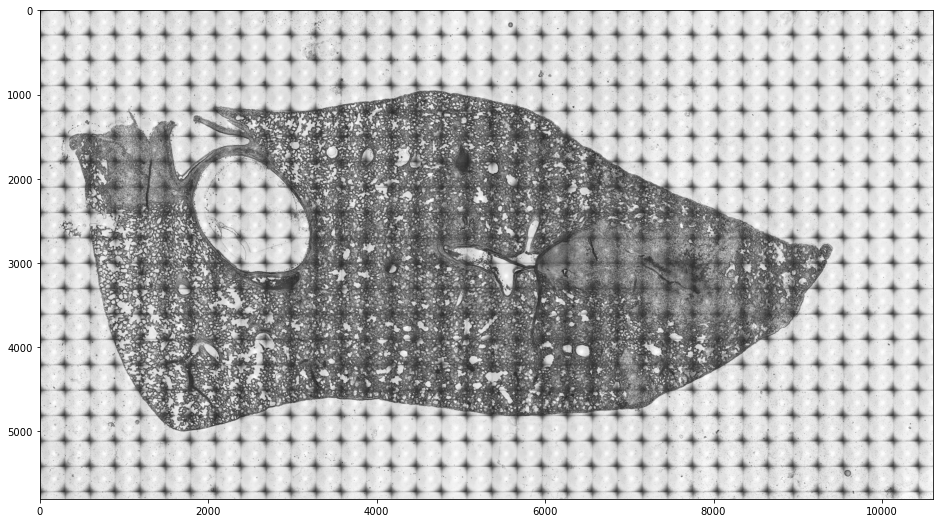

In [3]:
pano_img = imageio.imread(pano_name)
plt.figure(figsize=(16,12))
plt.imshow(pano_img[...,:3]);

## Flatfield calculation and correction

In [4]:
def get_flat_shape(im):
    fly = np.mean(im, 1)
    flx = np.mean(im, 0)
    window_x = int(np.round(get_window_size(flx)))
    window_y = int(np.round(get_window_size(fly)))
    return window_y, window_x

def compute_flat_tile(im):
    ny, nx = get_flat_shape(im)
    arr = da.from_array(im, chunks=(ny,nx))
    npixels = ny * nx
    arr = da.stack([b for b in arr.blocks.ravel() if b.size==npixels])
    flat = da.median(arr, axis=0).compute()
    flat = flat / np.median(flat)
    return flat

def get_flat(im, flat):
    def _cor(im):
        ny,nx = im.shape
        return flat[:ny,:nx]

    ny, nx = flat.shape
    arr = da.from_array(im, chunks=flat.shape)
    return arr.map_blocks(_cor, dtype="float32").compute()
                            

def gfunc(theta, x):
    return theta[0] * np.exp(-0.5 * ((x - theta[1]) / theta[2]) ** 2) + theta[3]


def min_func(theta, x, y):
    ys = gfunc(theta, x)
    return np.sum((y - ys) ** 2)


def get_window_size(fl):
    x = np.arange(len(fl))
    # substracting large scale background
    c = np.polyfit(x, fl, 11)
    f_sub = fl - np.polyval(c, x)
    # this onlu leaves the negative peaks
    thr = np.std(f_sub)
    f_mask = (-1.0 * (f_sub)).clip(thr, 1e7)

    ff = np.fft.fft(f_mask)
    fr = np.fft.fftfreq(f_mask.size)
    p = np.abs(ff)

    fr, p = LombScargle(x, f_mask).autopower(
        minimum_frequency=1.0 / 400, maximum_frequency=1.0 / 200.0
    )

    ii = np.where((1.0 / fr > 200) & (1.0 / fr < 600))[0]
    im = np.argmax(p[ii])
    ii = slice(ii[im] - 5, ii[im] + 5)

    res = minimize(
        min_func,
        [1.0, np.mean(fr[ii]), 1e-3, np.min(p[ii]) / np.max(p[ii])],
        args=(fr[ii], p[ii] / np.max(p[ii])),
        method="powell",
    )
    wx = 1.0 / res["x"][1]

    return wx

### Compute the flat for each tile and the stage flat

In [5]:
im = pano_img[...,0]
flat_tile = compute_flat_tile(im)
flat = get_flat(im, flat_tile)

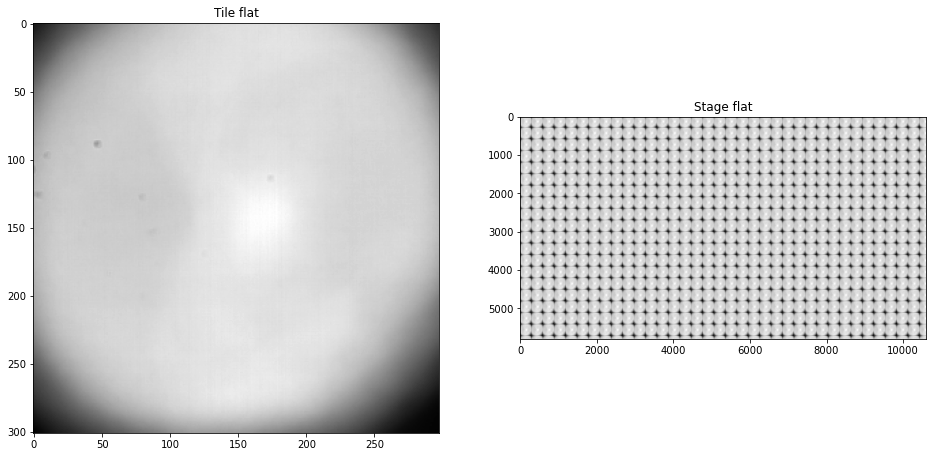

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,12))
ax[0].imshow(flat_tile, cmap="gray"); ax[0].set_title("Tile flat")
ax[1].imshow(flat, cmap="gray"); ax[1].set_title("Stage flat");

### Flat correct stage

Note we only correct one channel as they are all the same. The ouput corrected image is `pano_img_corr`


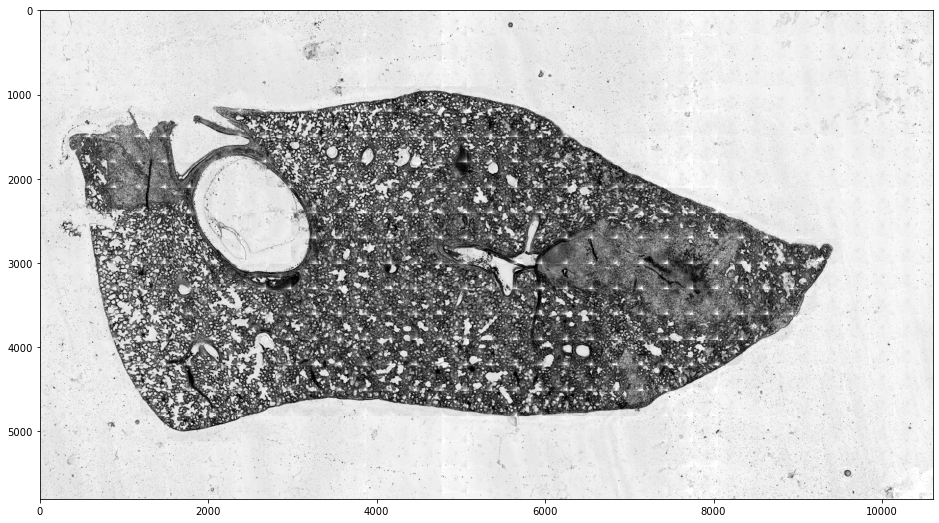

In [7]:
pano_img_corr = pano_img[...,0] / flat
pano_img_corr = (pano_img_corr - pano_img_corr.min()) / (pano_img_corr.max() - pano_img_corr.min())

plt.figure(figsize=(16,12))
p = PercentileInterval(99)
p1, p2 = p.get_limits(pano_img_corr.ravel())
plt.imshow(pano_img_corr, cmap="gray", vmin=p1, vmax=p2);